In [113]:
import csv
import os

import numpy as np
import pandas as pd
from owid_downloader import GenerateTrainingData
from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [114]:
#GenerateTrainingData().download_jhu_data('2020-08-01', '2020-12-01')
start_date = '2021-01-01'
end_date = '2021-05-31'
# start with top 30 most populated countries
'''
countries = ['China', 'India', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Nigeria', 'Bangladesh',
            'Russia', 'Mexico', 'Japan', 'Ethiopia', 'Philippines', 'Egypt', 'Vietnam', 'Congo', 'Turkey', 'Iran',
            'Germany', 'Thailand', 'United Kingdom', 'France', 'Italy', 'South Africa', 'Myanmar',
            'Kenya', 'South Korea', 'Colombia', 'Spain']
'''

"\ncountries = ['China', 'India', 'United States', 'Indonesia', 'Pakistan', 'Brazil', 'Nigeria', 'Bangladesh',\n            'Russia', 'Mexico', 'Japan', 'Ethiopia', 'Philippines', 'Egypt', 'Vietnam', 'Congo', 'Turkey', 'Iran',\n            'Germany', 'Thailand', 'United Kingdom', 'France', 'Italy', 'South Africa', 'Myanmar',\n            'Kenya', 'South Korea', 'Colombia', 'Spain']\n"

In [115]:
#Merge population data with downloaded data
#raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
#pop_data = pd.read_csv('./uszips.csv')
#pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
#raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')
raw_data = pd.read_csv('owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date) # & (raw_data['location'].isin(countries))
raw_data = raw_data.loc[mask]
#print(raw_data[raw_data['location'] == 'United States']['total_cases'].values[0])
countries = []
loc_list = list(raw_data['location'].unique())
# remove countries that have little or poor data (no reported deaths)
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded for now; these are problematic locations that need to be removed
countries.remove("International")
countries.remove("Tanzania")
countries.remove("Tajikistan")
countries.remove("European Union")
countries.remove("Europe")
countries.remove("Africa")
countries.remove("Asia")
countries.remove("North America")
countries.remove("Oceania")
countries.remove("South America")
countries.remove("World")
# still need to remove some of the locations, e.g., "Europe"
#print(len(countries))
mask = raw_data['location'].isin(countries)
raw_data = raw_data.loc[mask]
#print(raw_data[raw_data['location'] == 'United States'].head())

In [116]:
'''
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)
'''
# Flights
# will need to re-make edges for every layer of the graph based on date
# for now will just use # flights on 2021-01-01
flight_list = pd.read_csv('flights_by_country_2021-01-copy.csv')
flight_list['day'] = pd.to_datetime(flight_list['day'])
flight_list = flight_list[flight_list['day'] == '2021-01-01']
loc_list = list(raw_data['location'].unique())
loc_flight_map = {}
for each_loc in loc_list:
    loc_flight_map[each_loc] = {}
    for each_loc2 in loc_list:
        loc_flight_map[each_loc][each_loc2] = len(flight_list[(flight_list['origin_country'] == each_loc)
                                            & (flight_list['destination_country'] == each_loc2)])
print(loc_list)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jor

In [117]:
#Generate Graph

dist_threshold = 0

for each_loc in loc_flight_map:
    loc_flight_map[each_loc] = {k: v for k, v in sorted(loc_flight_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
# adding edges to top 4 most outgoing flight countries
adj_map = {}
for each_loc in loc_flight_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_flight_map[each_loc]):
        if loc_flight_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i < 1:
                adj_map[each_loc].append(each_loc)
            else:
                break
print(adj_map)

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))
print(rows)
print(cols)

{'Afghanistan': ['Afghanistan'], 'Albania': ['Albania'], 'Algeria': ['Algeria'], 'Andorra': ['Andorra'], 'Angola': ['Angola'], 'Antigua and Barbuda': ['Antigua and Barbuda'], 'Argentina': ['Argentina'], 'Armenia': ['Armenia'], 'Australia': ['Singapore', 'United States', 'New Zealand', 'Hong Kong'], 'Austria': ['Germany', 'Spain', 'Denmark', 'Belgium'], 'Azerbaijan': ['Azerbaijan'], 'Bahamas': ['Bahamas'], 'Bahrain': ['United Arab Emirates', 'Hong Kong', 'India', 'Saudi Arabia'], 'Bangladesh': ['Bangladesh'], 'Barbados': ['United States', 'Canada'], 'Belarus': ['Ukraine', 'Germany', 'Lithuania', 'Russia'], 'Belgium': ['France', 'Italy', 'Turkey', 'Germany'], 'Belize': ['United States'], 'Benin': ['Benin'], 'Bolivia': ['Bolivia'], 'Bosnia and Herzegovina': ['Bosnia and Herzegovina'], 'Botswana': ['Botswana'], 'Brazil': ['United States', 'Panama', 'Portugal', 'France'], 'Brunei': ['Australia', 'Indonesia', 'Malaysia', 'Singapore'], 'Bulgaria': ['Bulgaria'], 'Burkina Faso': ['Burkina Faso'

<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=174, num_edges=362,
      ndata_schemes={}
      edata_schemes={})>
174


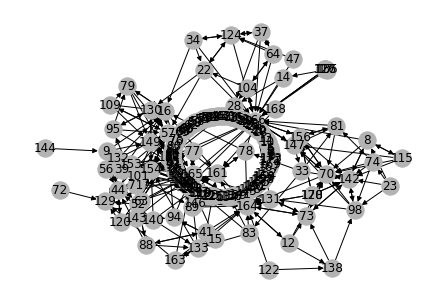

In [118]:
g = dgl.graph((rows, cols))
print(g.number_of_nodes)
import networkx as nx
nx_g = g.to_networkx()
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])
print(len(loc_list))

In [119]:
#Preprocess features

#active_cases = []
confirmed_cases = []
new_cases = []
new_vaccinations = []
fully_vaccinated = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    #active_cases.append(raw_data[raw_data['state'] == each_loc]['active'])
    confirmed_cases.append(raw_data[raw_data['location'] == each_loc]['total_cases'])
    new_cases.append(raw_data[raw_data['location'] == each_loc]['new_cases'])
    new_vaccinations.append(raw_data[raw_data['location'] == each_loc]['new_vaccinations'])
    fully_vaccinated.append(raw_data[raw_data['location'] == each_loc]['people_fully_vaccinated'])
    death_cases.append(raw_data[raw_data['location'] == each_loc]['total_deaths'])
    static_feat.append(np.array(raw_data[raw_data['location'] == each_loc][['population']]))
confirmed_cases = np.nan_to_num(np.array(confirmed_cases))
death_cases = np.nan_to_num(np.array(death_cases)[:, 14:])
new_cases = np.nan_to_num(np.array(new_cases)[:, 14:])
new_vaccinations = np.nan_to_num(np.array(new_vaccinations)[:, 14:])
fully_vaccinated = np.nan_to_num(np.array(fully_vaccinated))
static_feat = np.nan_to_num(np.array(static_feat)[:, 0, :])

import copy
# active = confirmed(today) - confirmed(14 days ago)
cases_copy = copy.deepcopy(confirmed_cases)
active = []
for loc in confirmed_cases:
    active_loc = []
    for i in range(14, len(loc)):
        active_loc.append(loc[i] - loc[i-14])
    active.append(active_loc)
active_cases = np.array(active)

confirmed_cases = confirmed_cases[:, 14:]
fully_vaccinated = fully_vaccinated[:, 14:]

recovered_cases = confirmed_cases - active_cases - death_cases + 0.94*fully_vaccinated
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)
print("done")

done


In [120]:
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))

In [121]:
def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R

In [122]:
valid_window = 25
test_window = 25

history_window=6
pred_window=15
slide_step=5

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
for i, each_loc in enumerate(loc_list):
    dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
    dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
    dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]

dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], history_window, pred_window, slide_step)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], history_window, pred_window, slide_step)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], history_window, pred_window, slide_step)

In [123]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [124]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=2, bias=True)
)

In [125]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [126]:
#Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = 'United Kingdom'
cur_loc = loc_list.index(loc_name)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    loss = criterion(active_pred.squeeze(), train_yI[cur_loc])+criterion(recovered_pred.squeeze(), train_yR[cur_loc])+0.1*criterion(phy_active.squeeze(), train_yI[cur_loc])+0.1*criterion(phy_recover.squeeze(), train_yR[cur_loc])
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)
    
    val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc]) + 0.1*criterion(val_phy_active.squeeze(), val_yI[cur_loc])
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss
        print('-----Save best model-----')
    
    print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

C:\Users\conni\anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
-----Save best model-----
Epoch 0, Loss 1317.10, Val loss 0.76
Epoch 1, Loss 2.92, Val loss 0.85
Epoch 2, Loss 3.95, Val loss 0.89
Epoch 3, Loss 4.69, Val loss 0.88
Epoch 4, Loss 4.58, Val loss 0.88
-----Save best model-----
Epoch 5, Loss 4.60, Val loss 0.73
-----Save best model-----
Epoch 6, Loss 4.04, Val loss 0.70
Epoch 7, Loss 4.29, Val loss 0.78
Epoch 8, Loss 4.18, Val loss 0.74
-----Save best model-----
Epoch 9, Loss 3.94, Val loss 0.66
Epoch 10, Loss 4.07, Val loss 0.71
-----Save best model-----
Epoch 11, Loss 4.28, Val loss 0.66
-----Save best model-----
Epoch 12, Loss 4.18, Val loss 0.64
-----Save best model-----
Epoch 13, 

In [127]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)


In [128]:
print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)

Estimated beta in SIR model is 0.22
Estimated gamma in SIR model is 0.61


In [129]:
#Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    #cur_pred = test_pred_phy_active[0, i, :].detach().cpu().numpy()
    cur_pred = (cur_pred + test_pred_phy_active[0, i, :].detach().cpu().numpy()) / 2
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)
pred_I = pred_I

In [130]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [131]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

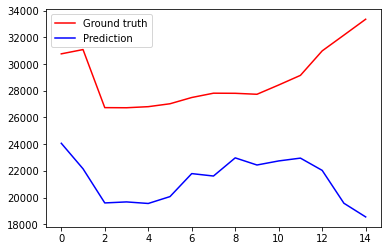

In [132]:
plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
plt.plot(pred_I[-1, :],c='b', label='Prediction')
plt.legend()
plt.show()